<a href="https://colab.research.google.com/github/colinjhorgan/MLTSA22_CHorgan/blob/main/HW5/CH_HW5_Revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<font color="red"> FBB excellent work !</font>

In [ ]:
import numpy as np
import pandas as pd
import pylab as plt
%pylab inline

from sklearn import cluster
from sklearn.metrics import pairwise_distances

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive/MyDrive/3.\ MSDS\ Courses/Machine\ Learning\ Time\ Series

/content/gdrive/MyDrive/3. MSDS Courses/Machine Learning Time Series


# Reading in Data

Data on world population by country taken from World Bank.

https://data.worldbank.org/indicator/SP.POP.TOTL

In [ ]:
#Import Data from World Bank, coerce into usable dataframe for clustering
path = 'World_Bank/WorldPopByCountry.csv'
cpop = pd.read_csv(path, header=2)
drop_list = cpop.columns[1:4].union(cpop.columns[[-1]]) #drop columns not used for clustering
cpop.drop(columns=drop_list, inplace=True)
cpop = cpop.T
cpop.columns = cpop.iloc[0,:]
cpop.drop(['Country Name'], inplace=True)
cpop

Country Name,Aruba,Africa Eastern and Southern,Afghanistan,Africa Western and Central,Angola,Albania,Andorra,Arab World,United Arab Emirates,Argentina,...,Virgin Islands (U.S.),Vietnam,Vanuatu,World,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
1960,54208.0,130836765.0,8996967.0,96396419.0,5454938.0,1608800.0,13410.0,92197715.0,92417.0,20481781.0,...,32500.0,32670048.0,63689.0,3032156070.0,108627.0,947000.0,5315351.0,17099836.0,3070780.0,3776679.0
1961,55434.0,134159786.0,9169406.0,98407221.0,5531451.0,1659800.0,14378.0,94724540.0,100801.0,20817270.0,...,34300.0,33666111.0,65700.0,3071596055.0,112112.0,966000.0,5393034.0,17524533.0,3164330.0,3905038.0
1962,56234.0,137614644.0,9351442.0,100506960.0,5608499.0,1711319.0,15379.0,97334438.0,112112.0,21153042.0,...,35000.0,34683410.0,67793.0,3124561005.0,115768.0,994000.0,5473671.0,17965733.0,3260645.0,4039209.0
1963,56699.0,141202036.0,9543200.0,102691339.0,5679409.0,1762621.0,16407.0,100034191.0,125130.0,21488916.0,...,39800.0,35721213.0,69944.0,3189655687.0,119552.0,1022000.0,5556767.0,18423157.0,3360099.0,4178726.0
1964,57029.0,144920186.0,9744772.0,104953470.0,5734995.0,1814135.0,17466.0,102832792.0,138049.0,21824427.0,...,40800.0,36780001.0,72116.0,3255145692.0,123346.0,1050000.0,5641598.0,18896303.0,3463211.0,4322854.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,104865.0,609978946.0,35383028.0,412551299.0,28842482.0,2876101.0,77295.0,404042892.0,9360975.0,43590368.0,...,107516.0,93640435.0,278326.0,7433569330.0,194540.0,1777557.0,27168210.0,56207649.0,16363449.0,14030338.0
2017,105361.0,626392880.0,36296111.0,423769930.0,29816769.0,2873457.0,76997.0,411942825.0,9487206.0,44044811.0,...,107281.0,94600643.0,285499.0,7519183459.0,195358.0,1791003.0,27834811.0,57009751.0,16853608.0,14236599.0
2018,105846.0,643090131.0,37171922.0,435229381.0,30809787.0,2866376.0,77008.0,419851989.0,9630966.0,44494502.0,...,107001.0,95545959.0,292675.0,7602454161.0,196128.0,1797085.0,28498683.0,57792520.0,17351714.0,14438812.0
2019,106310.0,660046272.0,38041757.0,446911598.0,31825299.0,2854191.0,77146.0,427870273.0,9770526.0,44938712.0,...,106669.0,96462108.0,299882.0,7683372259.0,197093.0,1788878.0,29161922.0,58558267.0,17861034.0,14645473.0


In [ ]:
#Check for null values
cpop.isna().sum()[cpop.isna().sum() > 0]

Country Name
Eritrea                9
Not classified        61
Kuwait                 3
West Bank and Gaza    30
dtype: int64

Checking for null values reveals we had an unexpected column sneak into our datafame 'Not classified'. We'll have to remove that.

In [ ]:
cpop.drop(columns='Not classified', inplace=True)
cpop.shape

(61, 265)

# Data Imputation

We could just drop all of the columns that have missing data, but Eritrea and Kuwait are only missing 9 and 3 values respectively - so that could eliminate a lot of data. We should try to impute these values before we discard them.

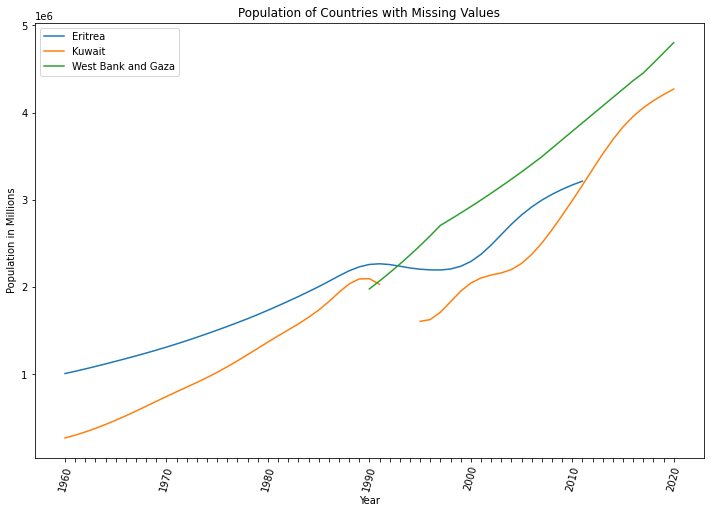

In [ ]:
#Plot populations of countries with missing data

#Get custom xlabels
dates = cpop.index.values.astype(int)
x_axis = np.where(dates%10==0, dates, '')

#Generate Plot
plt.figure(figsize=(12,8))
plt.plot(cpop[['Eritrea','Kuwait','West Bank and Gaza']])
plt.xticks(range(0,len(cpop.index)), x_axis, rotation=75)
plt.title('Population of Countries with Missing Values')
plt.xlabel('Year')
plt.ylabel('Population in Millions')
plt.legend(['Eritrea','Kuwait','West Bank and Gaza']);

**Figure 1: Plot of countries populations with missing data across time.** 

Kuwait looks like it could be reasonably imputed with a linear trend across the missing values. West Bank and Eritrea are more difficult. If someone was paying me to do this work I might try to predict out the population of Eritrea based on the trend or find supplementary data sources. For now we will just impute Kuwait and exclude West Bank and Eritrea from analysis

<font color="red"> FBB nice! and fair</font>

In [ ]:
#Drop Eritrea and West Bank
cpop.drop(columns=['Eritrea', 'West Bank and Gaza'], inplace=True)

#Impute missing values for Kuwait
cpop['Kuwait'] = cpop['Kuwait'].astype(float).interpolate('linear')
cpop['Kuwait'].isna().sum()

0

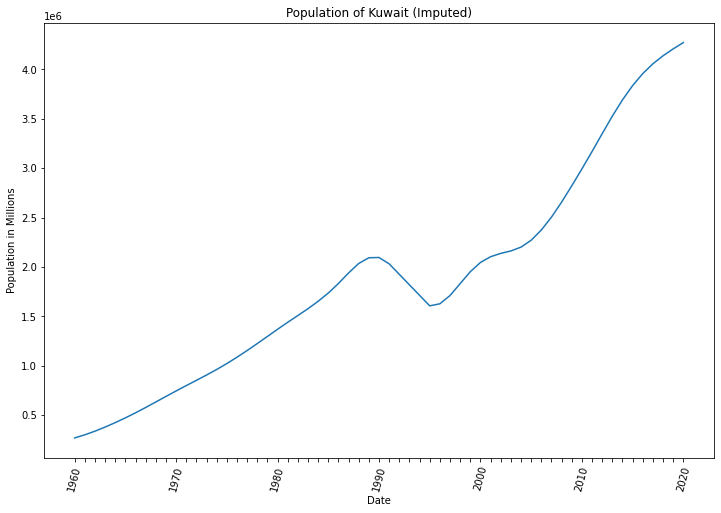

In [ ]:
#Plot Kuwait with missing values imputed
plt.figure(figsize=(12,8))
plt.plot(cpop['Kuwait'].astype(float).interpolate('linear'))
plt.xticks(range(0,len(cpop.index)), x_axis, rotation=75)
plt.title('Population of Kuwait (Imputed)')
plt.ylabel('Population in Millions')
plt.xlabel('Date');

**Figure 2: Population of Kuwait with missing Values imputed using a linear trend.**

The overall result here looks good enough to feel comfortable including Kuwait in our analysis.

# Visualizing our Data

We are dealing with a lot of countries. We want to know what type of patterns or trends we should be expecting or aware of before passing our data to a model of some kind.

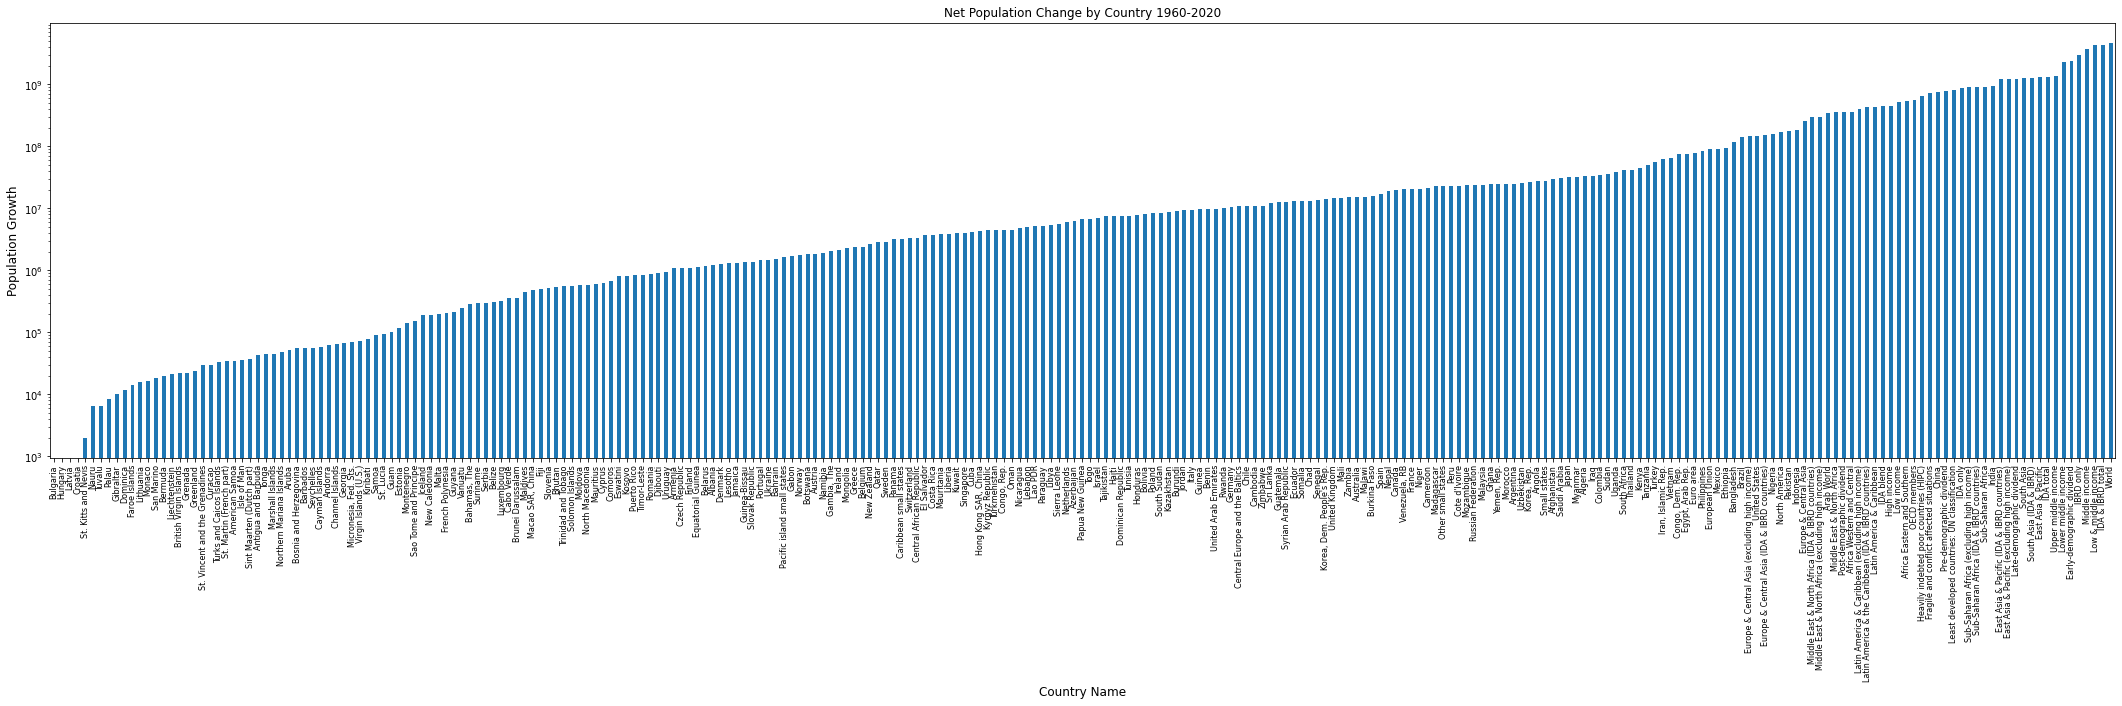

In [ ]:
pop_diff = cpop.iloc[-1,:] - cpop.iloc[0,:]

plt.figure(figsize=(37,8))
plt.xticks(fontsize=8)
plt.ylabel('Population Growth', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.title('Net Population Change by Country 1960-2020')
pop_diff.sort_values().plot.bar(logy=True);

**Figure 3: Total population increase across world countries from 1960-2020. Note that the y axis is in Log10.**

Overall, almost every country in the world's population increased from 1960-2020. Some exception may be Bulgaria, Hungary, Latvia, and Croatia. Note that on the far right, some data has been imported that is not related to any country but instead economic status. This is pretty cool and relevant to what we are trying to do, so we'll leave it in.

<font color="red"> FBB very good!</font>

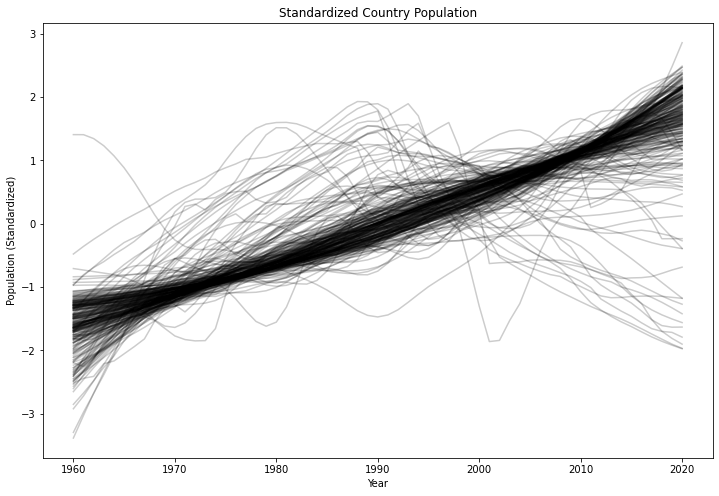

In [ ]:
#Preprocess data by standardizing and plot
X = (cpop - cpop.mean()) / cpop.std()

X.plot(alpha=.2, legend=False, color='black', figsize=(12,8))
plt.xlabel('Year')
plt.ylabel('Population (Standardized)')
plt.title('Standardized Country Population');

**Figure 4: Plot of Standardized Populations of Countries from 1960-2020. Each line represents one country.**

The above figure shows a large cluster of countries with somewhat of a linear pattern of growth (in the standardized scale). We can start to make out some countries whose population grew until 1990 and then later declined. Interestingly, it looks like one country's relative population severely dropped around 2000. This is country is Curacao.

<font color="red"> FBB good</font>

In [ ]:
X.iloc[2000-2019,:].index[np.argmin(X.iloc[2000-2019,:])]

'Curacao'

# Clustering Country Populations Across Time w/ K-Means

In [ ]:
#Clustering works by treating rows as the objects so we take the transpose of our data
X = X.T
k4 = cluster.KMeans(n_clusters=4).fit(X)

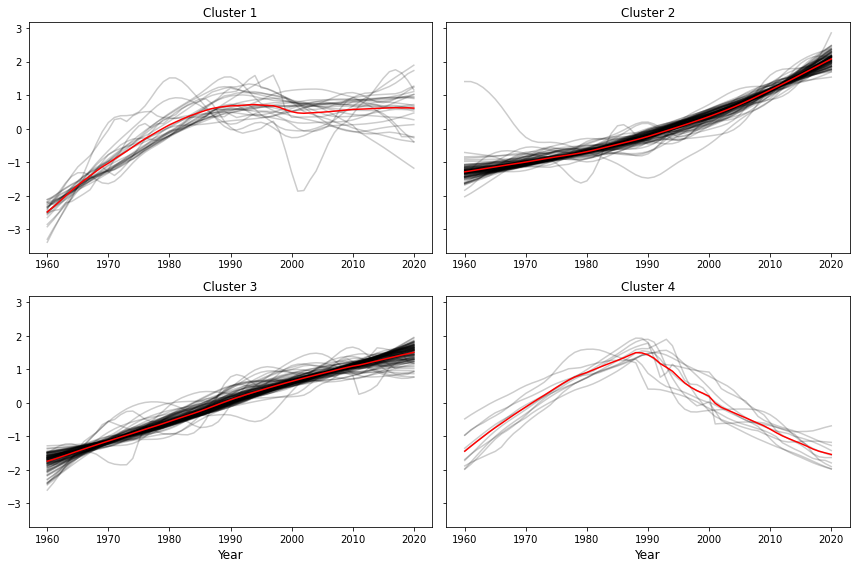

In [ ]:
#Plot clusters by label
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,8), sharey=True)
ax_list = [ax1,ax2,ax3,ax4]

for c in range(0,4):
  ax = ax_list[c]
  X[k4.labels_ == c].T.plot(legend=False, color='black', alpha=0.2, ax=ax)
  ax.plot(k4.cluster_centers_[c], c='r')
  ax.set_title(f'Cluster {c + 1}')
  if c > 1:
    ax.set_xlabel('Year', fontsize=12)

fig.tight_layout()

**Figure 4: Visualization of each cluster obtained by k-means clustering (k=4). Cluster centers are shown in red.**

The two largest clusters are clusters 2 and 3. Cluster 2 and 3 seem highly similar, with the difference seemingly being the bow of their trend. Cluster 4 seems to be capturing countries whose populations have been on the decline since 1990. Cluster 1 may be capturing populations which have been relatively stagnant in their size since 1990.

<font color="red"> FBB perfect</font>

# Which Countries Belong to the 2 Smallest Clusters?

In [ ]:
#Get names of countries which belong to cluster 1
print('Names of Countries in Cluster 1\n')
for country in X[k4.labels_==0].index:
  print(f'{country}')

Names of Countries in Cluster 1

Albania
Armenia
Belarus
Central Europe and the Baltics
Curacao
Czech Republic
Dominica
Faroe Islands
Greenland
Guyana
Japan
Kazakhstan
Moldova
North Macedonia
Montenegro
Poland
Puerto Rico
Russian Federation
Serbia
Slovak Republic
Slovenia
Tonga
St. Vincent and the Grenadines
Virgin Islands (U.S.)
Kosovo


The countries in cluster 1 seem to be smaller countries. Populations tend to not grow asymptotically. Usually when a population gets so large that the environment can't sustain any more growth - the population size will reach an equillibrium. Given these countries are relatively small, some of them have low GDP,  some are islands, and there don't seem to be any major historical events which connect them - this explanation seems reasonable to me.

<font color="red"> FBB in general when I researched it I found that for all these countries trends of emigrations  interfere with population growth and, somewhat serendipitously, this happened in the early 1990s in Eastern Europe due to specific sociopolitical events (fall of USSR) and for islands in central america around the same time. But thre are also some outliers that show slightly different trends in cluster 1 (St. Vincent and the Grenadines
 which in fact had a major weather event that contributed to the dip in early 2000</font>

In [ ]:
#Get names of countries which belong to cluster 4
print('Names of Countries in Cluster 4\n')
for country in X[k4.labels_==3].index:
  print(f'{country}')

Names of Countries in Cluster 4

Bulgaria
Bosnia and Herzegovina
Estonia
Georgia
Croatia
Hungary
Lithuania
Latvia
Romania
Ukraine


Countries in cluster 4 have a population decline after 1990. These countries are mostly situated around Russia, which collapsed as the Soviet Union in 1991. There are several wars that took place in the region after like the croatian war for independence, and several of these countries were involved in the gulf war (~1990). 

<font color="red"> FBB good</font>

# Calculating K-means Intra-Cluster Variance


In [ ]:
#We can calculate intra-cluster variance fairly easily since pandas and numpy
#are vectorized

k_vals = list(range(2,11))
var = []

i=0
for k in k_vals:
  cc = cluster.KMeans(n_clusters=k).fit(X) #cluster using kmeans
  mod_var = 0 #initialize model variance to zero

  for c in np.unique(cc.labels_):
    #Calculate variance of the cluster
    c_var = np.sum((X[cc.labels_ == c] - cc.cluster_centers_[c])**2).sum()
    mod_var += c_var #Add cluster variance to total model variance

  var.append(mod_var) #append to save data and iterate

#-------------------------------------------------------------------------------
var_df = pd.DataFrame({'K Value':k_vals,'Cluster Variance':var})

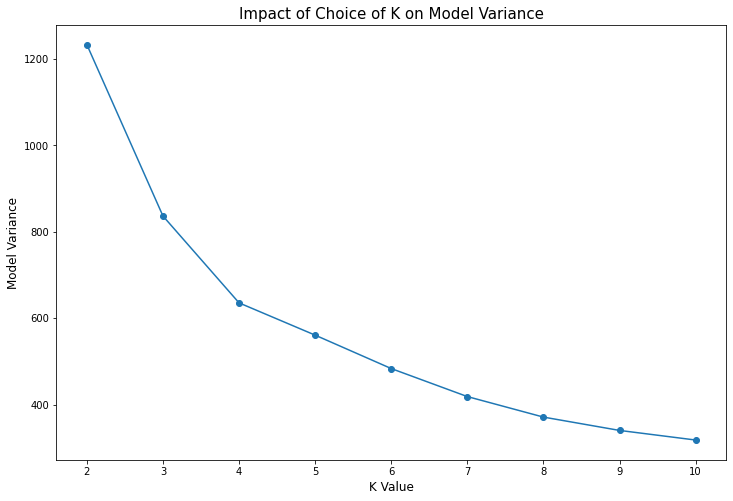

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(var_df['K Value'], var_df['Cluster Variance'])
ax.scatter(list(range(2,11)), var_df['Cluster Variance'])
ax.set_ylabel('Model Variance', fontsize=12)
ax.set_xlabel('K Value', fontsize=12)
ax.set_title('Impact of Choice of K on Model Variance', fontsize=15);

**Figure 5: Plot of total model intra-cluster variance as we change the value of k. Model variance was calculated by summing across the squared differences between each data point and its associated cluster center.**

Based off this plot, there doesn't seem to be a clear elbow in the model variance. 4 or 5 clusters would likely be optimal for this model.

<font color="red"> FBB good</font>

# Clustering Countries Populations w/ DBSCAN

The trouble with DBSCAN can be selecting a value for eps, which determines the distance at which 2 points can be considered neighbors. The following implementation of a methodology to select eps is taken from Gaonkar & Sawant, 2013. This is likely not the first paper to implement this methodology.

Gaonkar, M. N., & Sawant, K. (2013). AutoEpsDBSCAN: DBSCAN with Eps automatic for large dataset. International Journal on Advanced Computer Theory and Engineering, 2(2), 11-16.

In [ ]:
#Calculate distance to neighbors for all countries using minkowski distance p=2

n = X.shape[0] #distance matrix will be nxn where n is number of countries
dist_arr = np.zeros((n,n))

for i in range(0,n):
  for j in range(0,i): #To avoid duplicate calculations we stay below the diagonal
    dist_arr[i][j] = (np.sum((X.iloc[i,:] - X.iloc[j,:])**2))**(1/2)

dist_arr = dist_arr + dist_arr.T #To construct the whole matrix we add the transpose

In [ ]:
#We select k-neighbors of each point and calculate average distance to them

def k_avg_dist(arr, k):
  '''
  Calculates average distance to k-nearest neighbors given choice of k and a 
  distance matrix
  '''
  arr_sort = np.sort(arr)
  return np.sum(arr_sort[:,1:k+1], axis=1) / k

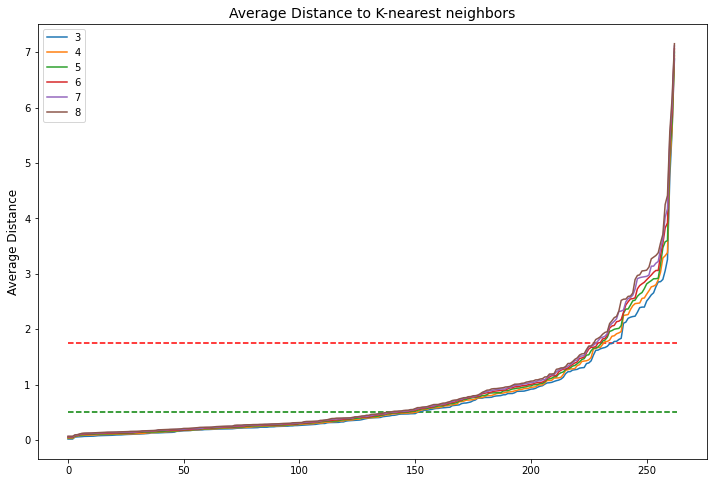

In [ ]:
#Plot sorted avg k-distances for different values of k
plt.figure(figsize=(12,8))

i = 0
for k in [3,4,5,6,7,8]:
  t = k_avg_dist(dist_arr,k)
  plt.plot(np.sort(t))
  i = i+1
plt.hlines(1.75,0,263, 'r', '--')
plt.hlines(0.5,0,263, 'g', '--')
plt.legend([3,4,5,6,7,8])
plt.ylabel('Average Distance', fontsize=12)
plt.title('Average Distance to K-nearest neighbors', fontsize=14);

**Figure 5: Average Minkowski Distance (p=2) of each country to its k-nearest neighbors, shown sorted in ascending order. The value of 'k' used to calculate average distances is indicated by the legend. Dashed red line indicates the 'elbow' in the plots and is located at y=1.75. Dashed green line indicates DBSCAN default eps value (0.5) in sklearn.**

Since the elbow in this plot remains pretty constant across choice of k, I am pretty comfortable using eps = 1.75 for DBSCAN. It's interesting to note here how far off our choice of eps would've been using the default eps in sklearn. There's a lesson here somewhere...

<font color="red"> FBB very nice!</font>

In [ ]:
#Use DBSCAN for Clustering
db = cluster.DBSCAN(eps=1.75, metric='euclidean').fit(X)

In [ ]:
np.unique(db.labels_,return_counts=True)

(array([-1,  0]), array([ 27, 236]))

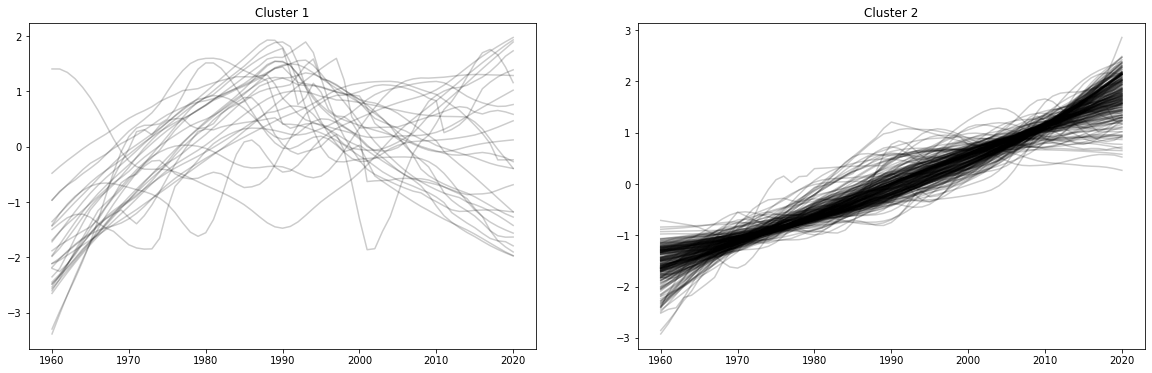

In [ ]:
#Plot cluster labels
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6))
ax_list = [ax1,ax2]

i=0
for c in np.unique(db.labels_):
  ax = ax_list[i]
  X[db.labels_ == c].T.plot(legend=False, color='black', alpha=0.2, ax=ax)
  ax.set_title(f'Cluster {i + 1}')
  i = i+1


**Figure 6: Clusters obtained with DBSCAN using euclidean distance with eps = 1.75.**

Whereas k-means returned 4 clusters, here we have only 2. It seems like the algorithm detected a large cluster of countries whose populations steadily increase, and then bagged everything else together in a single cluster. This type of behavior suggests we need to tune hyperparameters more, but we'll try one more thing and use correlation as a distance metric instead.

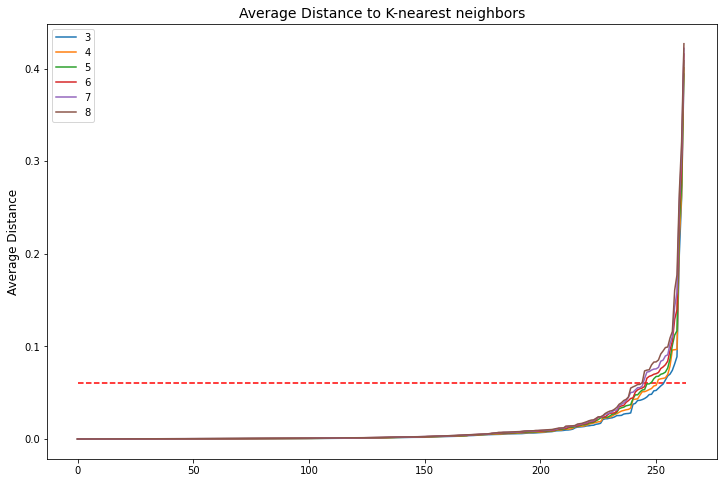

In [ ]:
#Using correlation distance
dist_arr = pairwise_distances(X, metric='correlation')

#Plot sorted avg k-distances for different values of k
plt.figure(figsize=(12,8))

i = 0
for k in [3,4,5,6,7,8]:
  t = k_avg_dist(dist_arr,k)
  plt.plot(np.sort(t))
  i = i+1
plt.legend([3,4,5,6,7,8])
plt.hlines(0.06,0,263,'r','--')
plt.ylabel('Average Distance', fontsize=12)
plt.title('Average Distance to K-nearest neighbors', fontsize=14);

**Figure 7: Average correlation distance between k-nearest neighbors. Legend indicates the value of k for each curve. Dashed red line indicates plot elbow at y=0.06.**

Choice of eps using correlation distance seems to be about 0.06.

In [ ]:
#Use DBSCAN for Clustering w/ correlation distance
db = cluster.DBSCAN(eps=0.06, metric='correlation').fit(X)
np.unique(db.labels_, return_counts=True)

(array([-1,  0,  1]), array([ 10, 248,   5]))

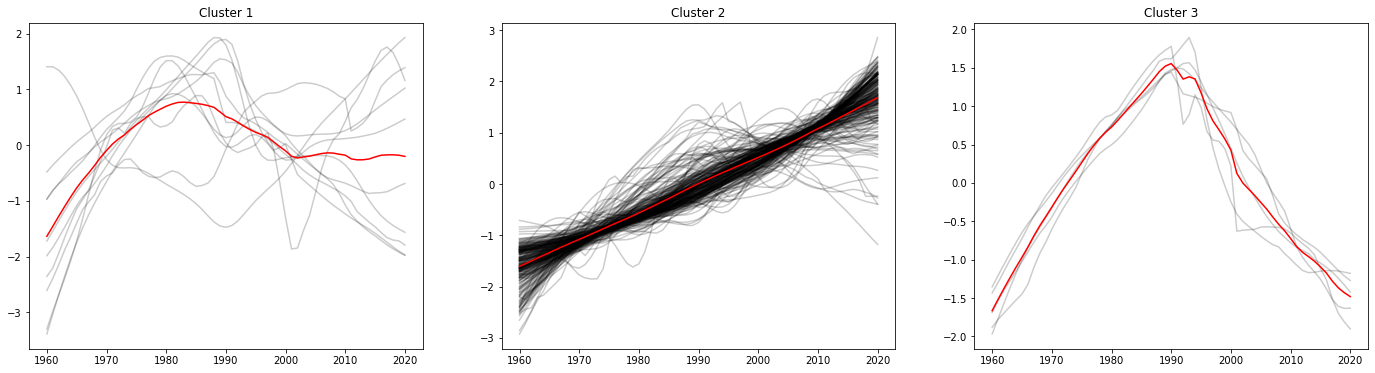

In [ ]:
#Plot cluster labels

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24,6))
ax_list = [ax1,ax2,ax3]

i=0
for c in np.unique(db.labels_):
  ax = ax_list[i]
  X[db.labels_ == c].T.plot(legend=False, color='black', alpha=0.2, ax=ax)
  ax.plot(X[db.labels_ == c].mean(), 'r')
  ax.set_title(f'Cluster {i + 1}')
  i = i+1

**Figure 8: Results of DBSCAN using correlation distance with eps=0.06, plotted by cluster. Cluster average shown in red.**

Using correlation distance has increased the number of clusters revealed by DBSCAN and gives us a result which looks a bit more reasonable than the previous model. There may be a few countries in the first cluster which look like we might ideally want them in cluster 3, but that's enough hyperparameter tuning for now. *Note that for both models we used the default value of min_samples=5. I played with this a bit 'off the record' and not much changed except you got more clusters with 1-2 countries in them.

In [ ]:
#Print countries in clusters 1 and 3
for c in [-1,1]:
  print(f'Countries in cluster {c+2}:\n')
  for country in X[db.labels_ == c].index:
    print(country)
  print('\n')


Countries in cluster 1:

Bulgaria
Bosnia and Herzegovina
Curacao
Germany
Dominica
Estonia
Guyana
Hungary
St. Kitts and Nevis
Latvia


Countries in cluster 3:

Georgia
Croatia
Lithuania
Romania
Ukraine




In [ ]:
#Calculate cluster variance
model_var = 0

for c in np.unique(db.labels_):
  model_var += np.sum((X[db.labels_==c] - X[db.labels_ == c].mean())**2).sum()

print(f'DBSCAN Cluster Variance w/ Correlation Distance: {model_var}')

DBSCAN Cluster Variance w/ Correlation Distance: 1513.2435296144004


# Discussion of K-means vs. DBSCAN Model Results

While our KMeans model gave us 4 clusters (as it was asked to) that all had seemingly coherent structures, the results of DBSCAN were less interpretable. When using euclidean distance to cluster countries, the algorithm returned two rather ambiguous clusters and even after hyperparameter tuning 'off the books' - its results where never that useful. This could be because we have 62 time points which means we have a 62 dimensional data space and euclidean distance gets arbitrarily large as you increase the dimensionality of your data (the so-called 'Curse of Dimensionality').

<font color="red"> FBB good</font>

Using correlation as a distance metric though, did produce interesting differences compared to euclidean distance. I thought that correlation would be a more useful metric since it doesn't rely on a summed difference between 2 time series. This model was able to pull out a cluster of countries with populations declining since 1990, and a cluster with somewhat of an ambiguous trend, as well as a large cluster containing the majority of countries who grew from 1960-2000. There is appropriate overlap between members of cluster 1 and 3 in this model and cluster 1 and 4 for our KMeans model.

<font color="red"> FBB ok (some questions about the choice of word... "apprioriate"...)</font>

Between Kmeans w/ k=4 and DBSCAN using correlation distance, I believe Kmeans makes the most sense here because the clusters it returns tell a more internally coherent story about the data. Further, this model has less variance. It is generally true that as you increase k, model variance decreases. However, I believe the lower variance here is more a factor of clusters adhering more closely to their centroids than those obtained by DBSCAN. In other words if we force DBSCAN to give us back 4 clusters, model variance will still be higher than K-Means

<font color="red"> FBB excellent work overall!</font>